# Deep Learning for Image Classification

In this homework, you will train a model to classify 10 characters in "*BanG Dream! It's MyGO!!!!!*" and "*BanG Dream! Ave Mujica*".

**TODO:**


*   Use PyTorch to train a model for image classification 使用 PyTorch 训练一个图像分类模型
*   Build **Convolutional Neural Network (CNN)** for image classification 构建用于图像分类的卷积神经网络（CNN）
*   Implement **data-augmentation** for image data 为图像数据实现数据增强操作
*   Use **pre-defined model** and **pre-trained weight** and fine-tune it for this task 选用预定义模型与预训练权重，并针对本任务对模型进行微调
*   ~~Make you model available for distinguishing Mortis from Mutsumi~~ 实现模型对角色 Mortis 与 Mutsumi 的区分功能

Dataset: https://github.com/steven-lunar/GenAI-ML-HW6.git

In [1]:
# Import Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import json
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# 资源目录
RES_DIR = "res/hw6/"

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Sat Jan 17 09:19:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.74                 Driver Version: 591.74         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P8             15W /  160W |     804MiB /  16303MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup the transformation for the training and inference phases

Here, we implement preprocessing on the image data we used. In the default setting, the original image size is 150 \* 150 \* 3, we resize it to 128 \* 128 \* 3.

You may change or add new transformations here to implement the data augmentation. Please ensure that the input image size is matched with your model input size.

## Data augmentation

You can use different transformations to "create" more training data for training your models.

(Image ref: https://www.ibm.com/think/topics/data-augmentation)

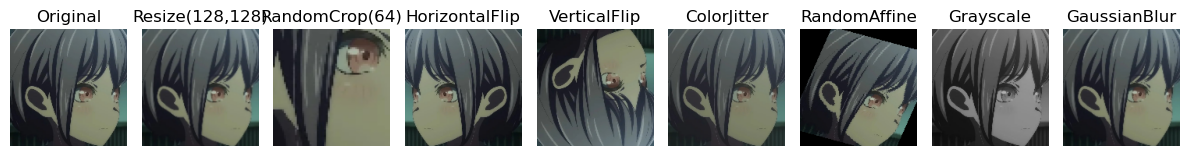

In [4]:
# Example for transformation

img_path = os.path.join(RES_DIR, "train/0.png")
img = Image.open(img_path).convert("RGB")

transform_list = {
    "Original": transforms.Compose([]),
    "Resize(128,128)": transforms.Resize((128, 128)),
    "RandomCrop(64)": transforms.RandomCrop(64),
    "HorizontalFlip": transforms.RandomHorizontalFlip(p=1.0),
    "VerticalFlip": transforms.RandomVerticalFlip(p=1.0),
    "ColorJitter": transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    "RandomAffine": transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    "Grayscale": transforms.Grayscale(num_output_channels=3),
    "GaussianBlur": transforms.GaussianBlur(kernel_size=9)
}

n = len(transform_list)
plt.figure(figsize=(12, 3))
for i, (name, t) in enumerate(transform_list.items()):
    transformed_img = t(img)
    plt.subplot(1, n, i + 1)
    plt.imshow(transformed_img)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [38]:
# # Train Transform
# train_transform = transforms.Compose([
#     transforms.Resize((128, 128)), # Resize to 128x128

#     # 训练时增强
#     transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转，概率50%，最基础且有效
#     transforms.RandomVerticalFlip(p=0.3), # 随机垂直翻转，概率30%
#     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1), # 颜色抖动，增强模型对颜色变化的鲁棒性
#     transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)), # 随机仿射变换，轻微平移和缩放
#     transforms.Grayscale(num_output_channels=3), # 转为灰度图再转回3通道，增强对颜色信息的鲁棒性
#     transforms.GaussianBlur(kernel_size=9), # 高斯模糊，模拟不同清晰度的图像

#     # Transform the numpy array to the torch tensor
#     transforms.ToTensor(),
#     # Normalize the tensor with mean and std
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Test Transform
# test_transform = transforms.Compose([
#     transforms.Resize((128, 128)), # Resize to 128x128

#     # 测试时增强
#     transforms.RandomHorizontalFlip(p=0.3), # 测试集仅用水平翻转即可，避免过度增强

#     # Transform the numpy array to the torch tensor
#     transforms.ToTensor(),
#     # Normalize the tensor with mean and std
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Train Transform
train_transform = transforms.Compose([
    # 1. 先 resize 到稍大的尺寸，为后续裁剪留空间
    transforms.Resize((256, 256)),
    # 2. 随机裁剪到 ResNet50 的标准输入尺寸
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),

    # 训练时增强
    # 3. 几何变换（适度）
    transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转，概率50%，最基础且有效
    transforms. RandomVerticalFlip(p=0.2), # 随机垂直翻转，概率20%
    transforms.RandomRotation(degrees=15), # 随机旋转，±15度内
    # 4. 颜色变换（适度）
    transforms.ColorJitter(
        brightness=0.3,      # 亮度变化 ±30%
        contrast=0.3,        # 对比度变化 ±30%
        saturation=0.3,      # 饱和度变化 ±30%
        hue=0.1             # 色调变化 ±10%
    ),
    # 5. 随机擦除（模拟遮挡，增强鲁棒性
    transforms.RandomApply([
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.15), ratio=(0.3, 3.3))
    ], p=0.3),
    # 6. 转换为 Tensor
    transforms.ToTensor(),
    # 7. 标准化（使用 ImageNet 的均值和标准差）
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test Transform
test_transform = transforms.Compose([
    # 1. Resize 到稍大尺寸
    transforms.Resize((256, 256)),
    # 2. 中心裁剪到 224x224（确定性操作）
    transforms.CenterCrop(224),
    # 3. 转换为 Tensor
    transforms.ToTensor(),
    # 4. 标准化（与训练集保持一致）
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create a table to convert the text label

We don't use the text label directly to train our model. Instead, we first encode the text label into a number representing a specific class (character), and then use them to train models.

Here we have 10 characters in our dataset, the size of this table is 10 of course.

In [6]:
#############################
## Don't modify this part, or you may get low accuracy on Judgeboi even with good training performance.

label2class = {
    "anon": 0,
    "mutsumi": 1,
    "nyamuchi": 2,
    "rana": 3,
    "sakiko": 4,
    "soyo": 5,
    "taki": 6,
    "tomori": 7,
    "uika": 8,
    "umiri": 9
    ## "mana": 10   ...only appears in few sences...
}

# Define the custom dataset for this task

In [7]:
##################################
## If you aren't familiar with Dataset in torch, don't modify this part!!!

class MyGOCharacterDataset(Dataset):
    def __init__(self, json_path, images_dir, transform=None):
        """
        Args:
            json_path (str): Path to the json file with the metadata for this dataset (eg. train.json, valid.json, test.json)
            images_dir (str): Path to the images directory (eg. ./train/)
            transform (callable, optional): The transformation set you create (train_transform)
        """
        self.images_dir = images_dir
        self.transform = transform

        ## load metadata
        with open(json_path, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        attr = self.metadata[idx]
        img_path = os.path.join(self.images_dir, attr['filename'])
        idx = attr["id"]
        ## Images are opened with RGB channels, 3 channels
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            ## If there is transformations defined, we implement these transformations on our images
            image = self.transform(image)

        if "test" in self.images_dir:
            ## No label for the testing set, so we don't return labels
            return image, idx
        else:
            label = attr['label']
            label = label2class[label]
            return image, label, idx

###########################################

# Create the subsets for data

We load splited datasets as the training, validation and testing set.

In [8]:
train_set = MyGOCharacterDataset(
    json_path=os.path.join(RES_DIR, "train/train.json"),
    images_dir=os.path.join(RES_DIR, "train/"),
    transform=train_transform
)

val_set = MyGOCharacterDataset(
    json_path=os.path.join(RES_DIR, "valid/valid.json"),
    images_dir=os.path.join(RES_DIR, "valid/"),
    transform=train_transform
)

test_set = MyGOCharacterDataset(
    json_path=os.path.join(RES_DIR, "test/test.json"),
    images_dir=os.path.join(RES_DIR, "test/"),
    transform=test_transform
)

# Create Dataloader

We create dataloader to load our data, you can adjust the **batch size** here, it is also a hyperparameter that may make an impact on the performance. 我们创建数据加载器来读取数据，你可以在此处调整批量大小（batch size），这也是一个会对模型性能产生影响的超参数。

In [9]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Define the models

We define and build our own image classifier here. When you build your models, you should keep in mind that **a larger model is not always better than a small model**. Therefore, you aren't expected to build a huge model as a image classifier in this homework.

Also, you may pay attention on **the capacity of your google drive**. If there is no enough space for saving trained model weight, errors may occur during your training phase. As a reminder (or a hint), a model with <= 150 MB is large enough for you to pass the boss baseline.

我们将在此处定义并构建自定义的图像分类器。在搭建模型时，你需要牢记一点：**更大的模型并非总是优于更小的模型**。因此，本次作业并不要求你构建一个体量庞大的图像分类模型。

## Linear Model

Here we define a simple linear model as our image classifier.

**This model is so huge (~800 MB), be aware of available space of your google drive!!!**

(Disclaimer: This model is indeed a simple MLP, this model is so huge because the size of image.)


### Let's calculate the number of trainable parameters in this MLP model!!

- First linear layer: 128 \* 128 \* 3 \* 4096 (weight) + 4096 (bias) = 201330688 trainable parameters
- Second linear layer: 4096 * 512 (weight) + 512 (bias) = 2097664 trainable parameters
- Last linear layer: 512 * 10 (weight) + 10 (bias) = 5130 trainable parameters
- Total = 201330688 + 2097664 + 5130 = 203433482 trainable parameters

Each parameter is a 32-bit (4 bytes) floating number, so the model size is:
$$ \frac{203433482 \cdot 4}{1024 \cdot 1024} ≃ 776.04 (\text{MB})$$

What a huge model!!!

In [ ]:
class MyLinearModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## You may modify the linear model here to archieve better performance
        self.simple_linear = nn.Sequential(
            nn.Flatten(), # Flatten the image data into a 1D-vector
            nn.Linear(128 * 128 * 3, 512), # Fully-connected layer
            nn.ReLU(), # Activation function, ReLU here, can change it with other functions
            nn.Dropout(p=0.2),  # Randomly drop 20% of neurons to prevent overfitting
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes) # Using linear layer to map output with number of classes, 10
        )

    def forward(self, x):
        return self.simple_linear(x)

## Convolutional Neural Network (CNN)

A convolutional neural network is a model architecture that often used in image-related task.

A filter is used to extract features in the image. In CNN, we train models to learn these filters.

(Image ref: https://www.dragon1.com/terms/convolutional-neural-networks-definition)

### Let's calculate the number of trainable parameters in this basic CNN model!!

- First convolution layer: 3 \* 32 \* 3 \* 3 = 864  trainable parameters
- Second convolution layer: 32 \* 64 \* 3 \* 3 = 18432  trainable parameters
- First linear layer: 64 \* 2 \* 2 \* 32 + 32 = 8224 trainable parameters
- Second linear layer: 32 \* 10 + 10 = 330 trainable parameters
- Total: 864 + 18432 + 8224 + 330 = 27850 trainable parameters

Each parameter is a 32-bit (4 bytes) floating number, so the model size is:
$$ \frac{27850 \cdot 4}{1024 \cdot 1024} ≃ 0.11 (\text{MB})$$

Much smaller than the previous MLP model, right? However, it has much better performance than the MLP model!

In [42]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: Modify the CNN architecture here to get better performance
        ## - Wider
        ## - Deeper
        ## - Not so much downsample to preserve more information in the images (i.e. adjust the kernal size)
        ## - Dropout (nn.Dropout(p), reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)


        ## Pay attention to the input shape, it may not suit your modified model!!
        ## The default input shape here is [batch_size, 128, 128, 3]
        # self.simple_CNN = nn.Sequential(
        #     nn.Conv2d(3, 32, 3, 1, 1),      # Convolution layer to capture the features in the image
        #     nn.BatchNorm2d(32),             # Batch normalization
        #     nn.ReLU(),                      # Activation function
        #     nn.MaxPool2d(8, 8, 0),          # Maxpooling to downsample the image and only preserve important information

        #     nn.Conv2d(32, 64, 3, 1, 1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(8, 8, 0),

        #     nn.Flatten(),                   # Flatten the image data into a 1D-vector

        #     nn.Linear(64 * 2 * 2, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, num_classes)
        # )


        ## You may use the pre-defined model in this task
        ## You may choose the pre-defined model for yourself
        ## Useful pre-defined model list: https://docs.pytorch.org/vision/main/models.html
        

        ## Example:
        ## self.resnet18 = torchvision.models.resnet18(pretrained=False)

        ## You still need to modify the forward() function below to use these pre-defined models on the image
        ## Remember to check the input and output shape of these pre-defined models!

        # Load pre-trained ResNet50
        self.resnet50 = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Freeze all layers except the last few
        # This is crucial for small datasets to prevent overfitting
        for param in self.resnet50.parameters():
            param.requires_grad = False
        # Unfreeze the last residual block (layer4) for fine-tuning
        for param in self.resnet50.layer4.parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer to match our number of classes
        num_features = self.resnet50.fc.in_features  # 2048
        self.resnet50.fc = nn.Sequential(
            nn.Dropout(0.5),                      # 防止过拟合
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)

# Fix random seed for reproducibilty

You can fix a random seed to ensure the reproducibility of your experiment. You can also pick another random seed to seek better performance or use multiple models to implement ensemble for testing.

In [13]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(8128)

# Determine the saving directory

You can determine the directory to save your model weight and prediction files.

In [35]:
# 输出目录
OUTPUT_DIR = "output/hw6/"
# 模型保存目录
# save_dir = os.path.join(OUTPUT_DIR, 'linear/')
save_dir = os.path.join(OUTPUT_DIR, 'cnn/')
os.makedirs(save_dir, exist_ok=True)

# Training loop

This function define how we train the model with images and their corresponding labels. Again, be sure the capacity of your google drive is enough for saving model weight.

In [40]:
def train_model():
    ## Determine the number of epoch
    num_epochs=20

    # model = MyLinearModel().to(device)        ## Initialize the model
    model = MyCNNModel().to(device)        ## Initialize the model
    criterion = nn.CrossEntropyLoss()   ## Crossentropy loss function for classification task

    ## We use Adam as our optimizer here, you may change another optimizer
    ## Also, you can change the hyperparameters here, like the learning rate and the decay weight
    # optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    ## 学习率调度器
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    ## For storing the best accuracy on the validation set so far
    best_val_acc = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in range(num_epochs):
        model.train()       # Set model to the training phase, i.e., be able to optimize the weight in the model

        train_loss = 0
        train_correct = 0

        print("="*20, f"Epoch {epoch+1}/{num_epochs}", "="*20)
        for images, labels, idx in tqdm(train_loader):              # Iterating the training set with dataloader
            images, labels = images.to(device), labels.to(device)   # Put the training data (images and labels) to GPU
            optimizer.zero_grad()                                   # Clear the gradient computed with previous batch
            outputs = model(images)                                 # Put the image into model to get the result
            loss = criterion(outputs, labels)                       # Compute cross-entropy loss between the label and the model output
            loss.backward()                                         # Back propogation
            optimizer.step()                                        # Optimize the model weight

            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        scheduler.step()  # Update learning rate

        ## Compute the training loss and the accuracy for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)
        print(f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2%}")


        ## Validation phase

        val_correct = 0
        val_loss = 0
        model.eval()    # Set the model in evaluate phase
        with torch.no_grad():   # Set the gradient to zero
            for images, labels, idx in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / len(val_set)
        print(f"Valid Loss={avg_val_loss:.4f}, Valid Acc={val_acc:.2%}")


        ## Save the model weight with the best accuracy on the validation set
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(save_dir, 'best_model.pth')
            torch.save(model.state_dict(), save_path)
            print("Model saved (best validation acc.)")

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Validation Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    import glob
    for path in glob.glob(f"{save_dir}/*.pth"):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print("Your model size:")
        print(f"{path}: {size_mb:.2f} MB")

# Training

It may take about a few minutes to half an hour. If your training process is extremely slow, please check whether the GPU is activated or not.

==================== Epoch 1/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.22it/s]


Train Loss=2.4186, Train Acc=12.74%


100%|██████████| 10/10 [00:01<00:00,  7.86it/s]


Valid Loss=2.2316, Valid Acc=16.67%
Model saved (best validation acc.)
==================== Epoch 2/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.35it/s]


Train Loss=2.2439, Train Acc=19.96%


100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


Valid Loss=1.9765, Valid Acc=35.33%
Model saved (best validation acc.)
==================== Epoch 3/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


Train Loss=2.0344, Train Acc=29.59%


100%|██████████| 10/10 [00:01<00:00,  8.49it/s]


Valid Loss=1.8385, Valid Acc=43.00%
Model saved (best validation acc.)
==================== Epoch 4/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


Train Loss=1.8615, Train Acc=36.76%


100%|██████████| 10/10 [00:01<00:00,  8.47it/s]


Valid Loss=1.6635, Valid Acc=47.33%
Model saved (best validation acc.)
==================== Epoch 5/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


Train Loss=1.7133, Train Acc=41.25%


100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Valid Loss=1.5076, Valid Acc=50.00%
Model saved (best validation acc.)
==================== Epoch 6/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


Train Loss=1.6161, Train Acc=46.13%


100%|██████████| 10/10 [00:01<00:00,  8.24it/s]


Valid Loss=1.4245, Valid Acc=56.33%
Model saved (best validation acc.)
==================== Epoch 7/20 ====================


100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


Train Loss=1.4569, Train Acc=51.46%


100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Valid Loss=1.2532, Valid Acc=59.67%
Model saved (best validation acc.)
==================== Epoch 8/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Train Loss=1.3685, Train Acc=54.82%


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Valid Loss=1.1601, Valid Acc=64.00%
Model saved (best validation acc.)
==================== Epoch 9/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Train Loss=1.3067, Train Acc=56.40%


100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


Valid Loss=1.0562, Valid Acc=64.33%
Model saved (best validation acc.)
==================== Epoch 10/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Train Loss=1.2287, Train Acc=58.68%


100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


Valid Loss=1.1293, Valid Acc=61.67%
==================== Epoch 11/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.59it/s]


Train Loss=1.1459, Train Acc=61.91%


100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


Valid Loss=1.0644, Valid Acc=67.00%
Model saved (best validation acc.)
==================== Epoch 12/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Train Loss=1.1017, Train Acc=63.69%


100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


Valid Loss=0.9670, Valid Acc=65.67%
==================== Epoch 13/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.62it/s]


Train Loss=1.0381, Train Acc=65.40%


100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


Valid Loss=0.9459, Valid Acc=70.00%
Model saved (best validation acc.)
==================== Epoch 14/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Train Loss=1.0170, Train Acc=66.35%


100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


Valid Loss=0.8137, Valid Acc=72.67%
Model saved (best validation acc.)
==================== Epoch 15/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Train Loss=1.0397, Train Acc=65.53%


100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


Valid Loss=0.9145, Valid Acc=73.67%
Model saved (best validation acc.)
==================== Epoch 16/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Train Loss=0.9860, Train Acc=67.49%


100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


Valid Loss=0.8780, Valid Acc=70.33%
==================== Epoch 17/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Train Loss=1.0000, Train Acc=66.86%


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


Valid Loss=0.8426, Valid Acc=74.33%
Model saved (best validation acc.)
==================== Epoch 18/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.53it/s]


Train Loss=0.9873, Train Acc=66.48%


100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


Valid Loss=0.8576, Valid Acc=73.33%
==================== Epoch 19/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


Train Loss=0.9631, Train Acc=67.05%


100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


Valid Loss=0.7957, Valid Acc=74.00%
==================== Epoch 20/20 ====================


100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


Train Loss=0.9840, Train Acc=67.62%


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]

Valid Loss=0.8462, Valid Acc=73.67%


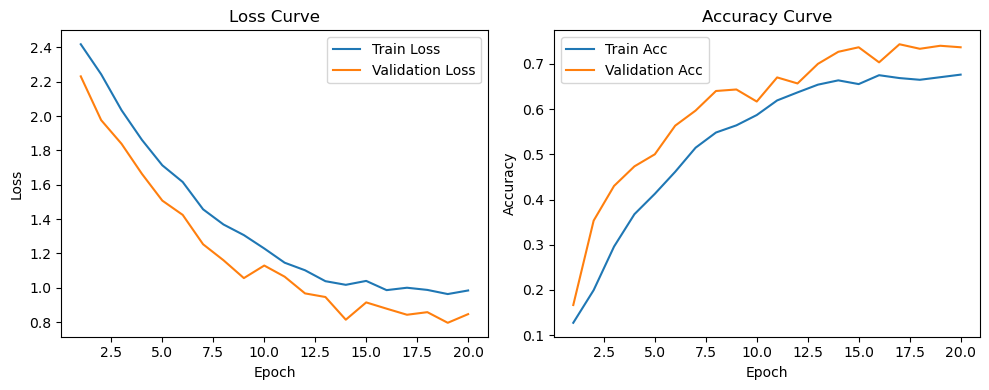

Your model size:
output/hw6/cnn\best_model.pth: 94.51 MB


In [43]:
train_model()   # Training

# Inference function

In this function, we load the model weight we just trained and use it as an image classifier to classify images into different characters.

After running this function, a json file containing predictions from your model should be produced and downloaded.

You json file must be like such format:

[
  
  {"id": 1878, "pred": 0},
  {"id": 1879, "pred": 1},
  ... (500 entries)

]

In [ ]:
def inference():
    ## Load the model weight to inference on the testing set
    model = MyLinearModel().to(device)
    ## Be sure that the model weight you loaded has the same architecture of the model you assign!
    ## That is, you cannot load a weight of "MyCNNModel" into a "MyLinearModel"
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')), strict=False)

    model.eval() # 切换模型至推理评估模式
    results = [] # 存储所有样本的预测结果
    idx_list = [] # 存储所有测试样本的id编号

    with torch.no_grad():  # 关闭梯度计算，提升推理速度并节省显存
        for images, idx in tqdm(test_loader):
            images = images.to(device)
            outputs = model(images)  # 模型推理输出，张量形状: [批次大小, 类别数量]
            preds = outputs.argmax(dim=1).cpu().tolist()  # 获取模型的预测类别

            results.extend(preds)
            idx_list.extend(idx.cpu().tolist())

    ## 生成json格式的预测结果文件

    final_output = []
    for (idx, result) in zip(idx_list, results):
      out = {
          "id": idx,
          "pred": result
      }
      final_output.append(out)

    ## Saving the prediction
    output_path = os.path.join(save_dir, "prediction.json")
    with open(output_path, "w") as f:
        json.dump(final_output, f, indent=4)


# Inferencing

It takes a few seconds to produce the prediction. Again, if the process is extremely slow, you should check whether the GPU is activated or not.

In [45]:
inference()   # Inferencing

100%|██████████| 16/16 [00:00<00:00, 22.53it/s]
